<a name="cell-MCMC-TOC"></a>

11. MCMC Diagnostics and Theory
  1. [Gibbs Sampling](#cell-MCint-gibbs)
  2. [Convergence / Markov Chain Mixing](#cell-MCint-sampling-MCMC-mixing)
  3. [Hamiltonian Dynamics and Metropolis-Hastings](#cell-MCint-sampling-MCMC-HMC2)
  4. [HMC Diagnostics](#cell-MCint-sampling-MCMC-diagnostics)
  5. [Transition Kernels](#cell-MCint-sampling-MCMC-transitionK)
  6. [Detailed Balance and Metropolis-Hastings](#cell-MCint-sampling-MCMC-db)



<a name="cell-MCint-gibbs"></a>

## 11.A Gibbs Sampling ([Return to TOC](#cell-MCMC-TOC))


---

The canonical example of ***Gibbs sampling*** is the ***normal-gamma*** model

$$\begin{align*}
p\left(x|\mu,\tau=\frac{1}{\sigma^2}\right) = {} & \prod_{i=1}^n \sqrt{\frac{\tau}{2\pi}} e^{-\frac{\tau}{2}(x_i-\mu)^2}\\
p(\mu,\tau) \propto {} & 1 \\
p(\mu,\tau| x) \propto p(\mu,\tau, x) \propto {} &  \tau^{n/2} e^{-\frac{\tau}{2} \sum_{i=1}^n (x_i-\mu)^2} \\
p(\tau|\mu, x) = {} & \text{Gamma}\left(\alpha = \frac{n}{2}+1, \beta= \frac{1}{2} \sum_{i=1}^n (x_i-\mu)^2 \right)\\
p(\mu| \tau, x)  \propto {} & e^{-\frac{\tau}{2} \sum_{i=1}^n \mu^2 - 2\mu x_i} =  e^{-\frac{\tau}{2} \left(n\mu^2 - 2\mu \sum_{i=1}^n x_i\right)} = e^{-\frac{\tau n }{2} \left(\mu^2 - 2\mu \bar x\right)}\\
  \propto {} & e^{-\frac{n \tau}{2} (\mu - \bar x)^2} \\
p(\mu| \sigma^2 = \tau^{-1}, x) = {} & N\left(E[\mu] = \bar x, Var(\mu) = \frac{\sigma^2}{n}\right)
\end{align*}$$

and see [here](https://bookdown.org/rdpeng/advstatcomp/gibbs-sampler.html) for the fully ***conjugate prior*** specification.



## 11.A Gibbs Sampling

---

In [1]:
from scipy import stats; import numpy as np; import matplotlib.pyplot as plt
n = 30; x = stats.norm.rvs(size=n); C,G = 2,100 # chains, Gibbs samples
mu,tau = np.zeros([C,G]),np.zeros([C,G]); mu[:,0] = 1000 # initialization
for c in range(C):
  for g in range(1,G):
    tau[c,g] = stats.gamma(a=n/2+1, scale=2/((x-mu[c,g-1])**2).sum()).rvs(size=1)[0]
    mu[c,g] = stats.norm(x.mean(), scale=1/np.sqrt(tau[c,g]*n)).rvs(size=1)[0]

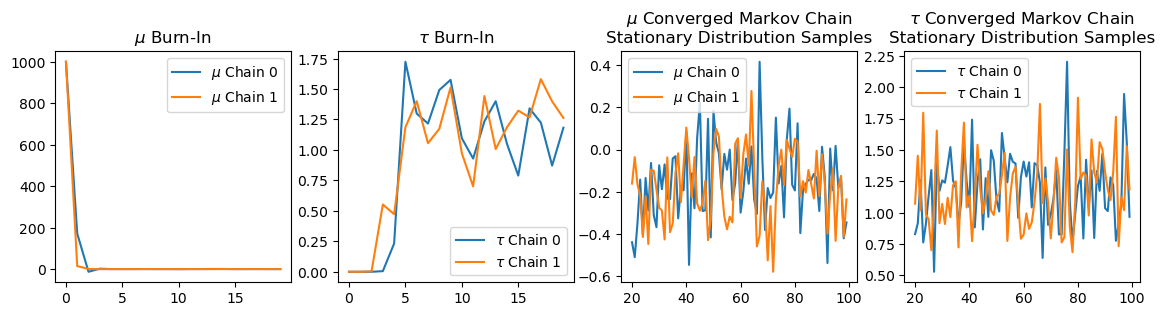

In [2]:
fig,ax = plt.subplots(1, 4, figsize=(14,3)); ax[0].set_title("$\\mu$ Burn-In"); ax[1].set_title("$\\tau$ Burn-In"); ax[2].set_title("$\\mu$ Converged Markov Chain\nStationary Distribution Samples"); ax[3].set_title("$\\tau$ Converged Markov Chain\nStationary Distribution Samples")
burn = 20
for c in range(C):
  ax[0].plot(mu[c,:burn], label="$\\mu$ Chain "+str(c)); ax[1].plot(tau[c,:burn], label="$\\tau$ Chain "+str(c)); ax[2].plot(np.arange(burn,G,dtype=int), mu[c,burn:], label="$\\mu$ Chain "+str(c)); ax[3].plot(np.arange(burn,G,dtype=int), tau[c,burn:], label="$\\tau$ Chain "+str(c))
ax[0].legend(); ax[1].legend(); ax[2].legend(); ax[3].legend(); 


The dependence between $x^{(t)}$ and $x^{(t')}$ decays as $|t-t'|$ increases. A less correlated sample could be constructed using subsequences of an ***MCMC chain***, but it this turns out to actually be wasteful.


<a name="cell-MCint-sampling-MCMC-mixing"></a>

## 11.B Convergence / Markov Chain Mixing ([Return to TOC](#cell-MCMC-TOC))

---

Given a sequence of samples $\theta^{(t)}$ produced  from a ***Markov chain***, e.g., constructed with ***Gibbs sampling***, it is proper and best practice to  

1. assess the ***mixing*** of the ***Markov chain*** 
  > which can be suggestive of ***convergence*** of the ***Markov chain*** to the ***stationary target distribution*** but does not guarantee it
2. discard initial ***burn-in*** samples of the chain which suggest the ***Markov chain*** is still in a ***warm-up*** regime rather than a ***convergence*** regime

***Warm-up*** (i.e., ***burn-in***) and ***convergence*** and of a ***Markov chain*** can be assessed by examining the agreement (i.e., "convergence") of multiple chains with different initial values $\theta^{(0)}$.

1. Once a chain is judged (by agreement with differently initialized chains) to likely no longer be in a ***warm-up*** regime
2. the initial "***burn-in*** samples" of the chain are discared
3. then the chain is run for additional iterations until its respresentation is no longer meaningfully altered by further extension of the chain
4. and finally all ***Markov chains*** that have been trimmed of their ***burn-in*** samples are combined into a single chain which is assumed to be appropriately representative of the ***stationary distribution*** of the ***Markov chain*** and hence the ***target distribuion*** of interest.

> It is at this point that the bias in the representation caused by the dependency in the chain is "washed out" and the dependent sequence of samples itself is (presumably) a representative sample of the ***stationary distribution*** (regardless of its sequential dependency).
>
> > This is why ***Markov chain Monte Carlo integration*** based on sequentially dependent samples can be used as a form of ***Monte Carlo integration***.

In order to assess the agreement of different chaines, $M$ split chains of $N$ samples created from $M/2$ chains havled in the middle are used to calculate the [split-$\hat R$ metric](https://arxiv.org/abs/1903.08008) which compares interchain and intrachain variance as

$$\text{split-}\hat R = \sqrt{\frac{\frac{N-1}{N}W +  \overbrace{\frac{1}{M-1}\sum_{m=1}^M (\overline{\theta^{(m,\cdot)}} - \overline{\theta^{(\cdot,\cdot)}})^2}^{\text{between chain variance}} }{\underbrace{\frac{1}{M}\sum_{m=1}^M \frac{1}{N-1}\sum_{n=1}^N (\theta^{(m,n)} - \overline{\theta^{(m,\cdot)}})^2}_{\text{$W$: within chain variance}}} } $$

which yields a value of $1$ for indistinguishable chians, and which has split-$\hat R < 1.05$ as the recommended threshold for diagnosing a set of Markov chains as sufficiently similar.

In [3]:
# Split-R-hat
# Split
chain = mu[:,burn:]#tau[:,burn:]
chain = chain.reshape(2*chain.shape[0], int(chain.shape[1]/2))
# R-hat
W = np.var(chain, ddof=1, axis=1).mean()
B = ((np.mean(chain, axis=1) - chain.mean())**2).sum()/(chain.shape[0]-1)
print("R-hat: ", np.sqrt((chain.shape[1]-1)/(chain.shape[1]-burn) + B/W))
# We should collect more samples... This is not yet suggestive of convergence

R-hat:  1.4001224421307792


<a name="cell-MCint-sampling-MCMC-HMC2"></a>

## 11.C Hamiltonian Dynamics and Metropolis-Hastings ([Return to TOC](#cell-MCMC-TOC))

---


> It's worth noting that due to numerical error in the discrete time approximation of the evolution of the ***Hamiltonian dynamics system*** we generally only have
>
> $$p(\theta_0, v_0|x) \approx p(\theta_t, v_t|x) \quad \text{ rather than } \quad p(\theta_0, v_0|x) = p(\theta_t, v_t|x)$$ 
>
> This, however, can just be viewed as additional noise that is just part of the $p(\theta_t, v_t+\epsilon|\theta_0, v_0)$ proposal process whose probabilities still only depend on the random proposal distributions for $t$ and $\epsilon$. Nonetheless, drifting too far away from the contour could result in a poor proposal if it drifts too far away from high ***energy*** values so that $p(\theta_t, v_t+\epsilon|x) << p(\theta_0, v_0|x)$ which means there will be a very low ***Metropolis-Hastings*** acceptance probability and would produce a ***sticky MH MCMC chain***. Thus, it is important to stay close to the the true ***energy*** contour. 
>
> This is why ***symplectic integrators*** such as the ***leap-frog integrator*** are very useful. They allow the ***Hamiltonian dynamics system*** to be evolved over time with minimal drift away from the intended ***energy*** contour based on the initial $(\theta_0, v_0)$ value.

Ideally, proposals taken from the parameter trajectories $\theta_0 \overset{time}{\rightarrow} \theta_t$ and $v_0 \overset{time}{\rightarrow} v_t+\epsilon$ would tend to be accepted with high probability to avoid a ***sticky MH MCMC chain*** and efficiently explore the sample space of the distribution.  But there is a tradeoff here.

- Longer trajectories along ***energy contours*** will tend to provide better exploration of the distribution; but, the longer a trajectory is run, the more numerical error can be expected so the less it actually approximates the trajectory of interest.  Thus, an evolved trajectory may not reasonably be able to travel too far from from its starting value and still maintaining a reasonably high ***energy*** level.  This is the case for even the best ***symplectic integrators*** such as the ***leap-frog integrator***. 

  > ***Symplectic integrators*** such as the ***leapfrog integrator*** are thus indispensable in the ***HMC*** context for reducing numerical error in ***Hamiltonian system evolution*** in order to create longer trajectories. The role of the ***leapfrog integrator*** in the full ***HMC*** workflow is nicely described in the ***Stan HMC software*** [reference manual](https://mc-stan.org/docs/2_19/reference-manual/hamiltonian-monte-carlo.html).


<a name="cell-MCint-sampling-MCMC-diagnostics"></a>

## 11.D HMC Diagnostics ([Return to TOC](#cell-MCMC-TOC))

---

In ***HMC*** the assessment of ***mixing*** is still diagnosed with split-$\hat R \leq 1.05$ suggestive of convergence of the ***Markov chain*** to its ***stationary distribution***. 

However, an additional characteristic of ***HMC*** is that its algorithmic performance can be inferred from its runtime behavior.

1. **energy countour trajectory step sizes**
  
   When discretely approximating parameter trajectories along ***energy contours*** of a probability distribution with step size $\delta$, the $p(\theta_t,v_t|x)$ should remain constant. Numerical instability such that $p(\theta_{t+\delta},v_{t+\delta}|x) \not \approx p(\theta_t,v_t|x)$ means the algorithm is failing.  This is caused by curvature in the ***energy*** function that is so excessive that $t+\delta$ discrete approximation of the ***Hamiltonian dynamics system*** is not small enough to follow the intended ***energy contours***. This creates a ***divergence*** in the ***energy*** which can be detected. Correspondingly adaptively shortening the step sizes length reduces ***divergences*** but also slows down the absolute progress of the trajectory away from its staring value.  Thus, any increasing computational cost of moving away from starting values under these (generally default) adaptive procedures is ***diagnostic*** of ***extreme distributional curvature***.

  - ***HMC*** sampling from distributions with ***extreme curvatures*** does not work well because it is computationally expensive to move away away from a position of ***high curvature*** while still maintaing the same energy level along the exiting trajectory; thus, the ***HMC chain*** created through ***high curvature regions*** is simultaneously computationally expensive while at the same time being unable to make progress away from previous samples in the ***HMC chain***. ***HMC chains*** in such regions are hence highly dependent, and thus of little informative value even with high sample counts, all while being extremely computationally expensive to obtain.

  - Models that entail regions of high curvature are untractable and must be avoided because ***HMC*** sampling of such models inevitably leads to misestimation and hence misuse. Reparameterizations or different probability model specifications that induce smoother distributions must be used instead of distributions causing computationally pathological sampling. 
  
2. **Metropolis-Hastings accepatance rates versus dependence in HMC chains**

   A ***HMC*** algorithm should achieve a decent ***Metropolis-Hastings proposal accepatance rate*** while producing samples that are not too highly correlated.  ***Metropolis-Hastings proposals*** that are too frequently rejected will produced a very ***sticky*** chain that will not efficiently explore the space of the distribution. ***HMC chains*** that are highly correlated are not providing efficient movement across the parameter space, and thus do not doing a good job of exploring the space of the distribution. A ***HMC*** scheme that achieves both a high ***Metropolis-Hastings proposal accepatance rate*** as well as produces ***HMS chains*** that are not too highly dependent can be extremely computationally efficient in exploring the space of the ***target stationary distribution***. On the other hand, ***HMC*** algorithmic performance that cannot quickly traverse (i.e., sample) the ***typical set*** of its ***target distribution*** while maintaing a desirable ***acceptance rate*** may be computationally intractible. 

  - Reducing trajectory lengths of discrete approximations to ***Hamiltonian dynamics*** used to generate parameter proposals and dampening the $\epsilon$ perturbations on the ***momentum proposals*** helps keep $p(\theta_t, v_t+\epsilon|x) \approx p(\theta_0, v_0|x)$ so that acceptance probabilities remain high; however, the ability to move $\theta_t$ far away from $\theta_0$ and fluidly transition between different ***energy contours*** of a probability distribution helps to decay the ***Markov dependence*** in ***HMC*** chains so that samples are less dependent and hence more efficiently explore the space of the probability distribution. 
  - ***Automatic tuning*** of ***acceptance rates*** for ***Metropolis-Hastings proposal steps*** are standard components of ***HMC*** algorithms.  Typically, an initially highly deviating proposal distribution will be increasingly muted until a target acceptance rate, e.g., $80\%$ is reached.  At that point it is hoped that the proposals are still typically far away from the previous samples so that dependency within the ***HMC chain*** is not too strong. Failure to achieve sufficiently large deviations is the result of numerically unstable ***Hamiltonian trajectory evolutions*** that must be shorted or overly volatile ***momentum*** perturbations that must be dampened.

3. **Effective samples sizes using split-$\hat R$**

  ***Effective sample size***

  $$n_{\text{eff}} = \frac{n}{\sum_{t=-\infty}^\infty\rho_t} = \frac{n}{1+2\sum_{t=1}^\infty\rho_t} \quad \text{ for order $t$ autocorrelations } \quad \rho_t $$

  can be estimated in ***Markov chain*** contexts with multiple ***chains***  based on [similar calculations](https://arxiv.org/abs/1903.08008) to those used for computing split-$\hat R$. Since $n_{\text{eff}}$ increases as the ***autocorrelations*** $\rho_t$ decrease, increasing $n_{\text{eff}}$ corresponds exactly to increasing ***MH proposal acceptance rates*** while reducing the the dependency in ***HMC chains***.  Thus, $n_{\text{eff}}$ gives a very simple way to evaluate the effectiveness of the balance between ***acceptance rates*** and ***HMC chain*** dependence. 

  - To reduce the depedence in ***HMC chains***, the ***energy contour*** trajectories could be extended. However, this would require additional computation, and it might actually be more computation efficient to just collect more ***HMC*** samples at the current $n_{\text{eff}}$ rates.     
  

<a name="cell-MCint-sampling-MCMC-transitionK"></a>

## 11.E Transition Kernels ([Return to TOC](#cell-MCMC-TOC))

---

Suppose the ***target distribution*** is Bernoulli with $p=2/3$, and the ***proposal distribution*** is Bernoulli  with $p=1/2$. The ***transition matrix*** is then 

\begin{align*}  {} &  \left[ \begin{array}{cc} \Pr(\theta^{(t)}=0| \theta^{(t-1)}=0 ) & \Pr(\theta^{(t)}=1| \theta^{(t-1)}=0 )\\  \Pr(\theta^{(t)}=0| \theta^{(t-1)}=1 ) & \Pr(\theta^{(t)}=1| \theta^{(t-1)}=1 )  \end{array}\right]\\
{} =  {} & \, \left[ \begin{array}{ll} \Pr(\tilde \theta^{(t)}=0) \times \frac{p(\tilde \theta^{(t)}=0|x)}{p(\theta^{(t-1)}=0|x)} & \Pr(\tilde \theta^{(t)}=1) \times  \frac{p(\tilde \theta^{(t)}=1|x)}{p(\theta^{(t-1)}=0|x)}\\  \Pr(\tilde \theta^{(t)}=0) \times \frac{p(\tilde \theta^{(t)}=0|x)}{p(\theta^{(t-1)}=1|x)} & \Pr(\tilde \theta^{(t)}=1) \times  \frac{p(\tilde \theta^{(t)}=1|x)}{p(\theta^{(t-1)}=1|x)} + \Pr(\tilde \theta^{(t)}=0) \times  \frac{p(\tilde \theta^{(t)}=0|x)}{p(\theta^{(t-1)}=1|x)}  \end{array}\right]\\
{} = & \left[ \begin{array}{ll} \frac{1}{2} \times 1 = \frac{1}{2} & \frac{1}{2} \times \min(1,\frac{2/3}{1/3}) = \frac{1}{2} \\  \frac{1}{2} \times \frac{1/3}{2/3} = \frac{1}{4} & \frac{1}{2} \times  1 + \frac{1}{2} \times (1- \frac{1/3}{2/3}) = \frac{3}{4} \end{array}\right]
\end{align*}
where the bottom right element of the matrix is the only situation where either proposal could lead to the desired transition since $\frac{p(\tilde \theta^{(t)}=1|x)}{p(\theta^{(t-1)}=0|x)} > 1$ means $\tilde \theta^{(t)}=1$ is always accepted when $\theta^{(t-1)}=0$. 

Raising the transition matrix to the $T^{th}$ power will result in any initial value of $\theta^{(0)}$ (i.e., any pointmass probability distribution $\delta_{\theta^{(0)}}$) into the desired Bernoulli target distribution. 

$$\underset{\begin{array}{c}\theta^{(0)}\;\; =\end{array}}{\begin{array}{c}\;\end{array}} \underset{\begin{array}{cc}0 & 1\end{array}}{\overbrace{\left[\begin{array}{cc}1&0\end{array}\right]}^{\text{initialization}}} 
\left[ \begin{array}{cc} \Pr(\theta^{(t)}=0| \theta^{(t-1)}=0 ) & \Pr(\theta^{(t)}=1| \theta^{(t-1)}=0 )\\  \Pr(\theta^{(t)}=0| \theta^{(t-1)}=1 ) & \Pr(\theta^{(t)}=1| \theta^{(t-1)}=1 )  \end{array}\right]^T 
\approx  \underset{\begin{array}{cc}0\; &\; \; 1\end{array}}{\left[\begin{array}{cc}1/3&2/3\end{array}\right]} \underset{\begin{array}{c}= \;\; \theta^{(t)}\end{array}}{\begin{array}{c}\;\end{array}}
$$

Another way to see this is to notice that for large enough $T$

$$\left[\begin{array}{cc}0.5 & 0.5\\0.25&0.75\end{array}\right]^t \approx \left[\begin{array}{cc}1/3& 2/3\\1/3&2/3\end{array}\right]$$

so all the rows of the exponentiated matrix will be the ***stationary distribution*** of the matrix, and thus any initialization row vector summing to 1 and left multiplied by this matrix must be the ***stationary distribution*** of the matrix.

In [ ]:
A = np.array([[.5,.5],[.25,.75]]) 
np.array([1/3,2/3]).dot(A)

array([0.33333333, 0.66666667])

In [ ]:
# intialize A and then multiply it by itself several times
#A = np.array([[.5,.5],[.25,.75]]) # np.array([1/3,2/3]).dot(A)
A = A.dot(A) # A**t will not work as it is element-wise
A

<a name="cell-MCint-sampling-MCMC-db"></a>

##  11.F Detailed Balance and Metropolis-Hastings ([Return to TOC](#cell-MCMC-TOC))

---
Some technical remarks that can be understoood in the context of the above example are as follows.
- The ***sationary distribution*** $\boldsymbol\pi_K$ of a ***Markov transition kernel*** $K$ is ***invariant*** under ***transition*** so that $\boldsymbol\pi_K = K(\boldsymbol\pi_K)$.
- The distribution of a ***converged Markov process*** is ***independent of starting state*** and is equal to the ***stationary distribution*** so that $K^T(\boldsymbol\pi^0) = \boldsymbol\pi_K$ for large enough $T$ regardless of the choice of $\boldsymbol\pi^0$.
- A ***Markov process*** will ***converge*** if it is ***ergodic*** which means it is 
  - ***irredicible*** so all states may be reached from all states
  - ***aperiodic*** so it is not deterministically cyclic

  and a sufficient (but not necessary) condition for this is ***detailed balance*** which requires that the process is 
  - ***reversible*** so $\tilde p(\boldsymbol\pi^{(t)}|\boldsymbol\pi^{(t-1)})p(\boldsymbol\pi^{(t-1)}|x) = \tilde p(\boldsymbol\pi^{(t-1)}|\boldsymbol\pi^{(t)})p(\boldsymbol\pi^{(t)}|x)$

> ***Metropolis-Hastings*** satisfies ***detailed balance*** and thus guarantees ***ergodicity***, and hence ***convergence***, since
> 
> $$\begin{align*}
\frac{p(\boldsymbol\pi^{(t)}|x)}{p(\boldsymbol\pi^{(t-1)}|x)} = \frac{\min\left(1, \frac{p(\boldsymbol\pi^{(t)}|x)}{p(\boldsymbol\pi^{(t-1)}|x)} \frac{\tilde p(\boldsymbol\pi^{(t-1)}|\boldsymbol\pi^{(t)})}{\tilde p(\boldsymbol\pi^{(t)}|\boldsymbol\pi^{(t-1)})}\right)}{\min\left(1, \frac{p(\boldsymbol\pi^{(t-1)}|x)}{p(\boldsymbol\pi^{(t)}|x)}\frac{\tilde p(\boldsymbol\pi^{(t)}|\boldsymbol\pi^{(t-1)})}{\tilde p(\boldsymbol\pi^{(t-1)}|\boldsymbol\pi^{(t)})}\right) } \frac{\tilde p(\boldsymbol\pi^{(t)}|\boldsymbol\pi^{(t-1)})}{\tilde p(\boldsymbol\pi^{(t-1)}|\boldsymbol\pi^{(t)})} = {} & \frac{\tilde p(\boldsymbol\pi^{(t)}|\boldsymbol\pi^{(t-1)})}{\tilde p(\boldsymbol\pi^{(t-1)}|\boldsymbol\pi^{(t)})}
\end{align*}$$
> 
> because either
> - the $\min$ function will evaluate to $1$ in the numerator (or the denomenator) since these terms are reciprocal, so the proposal ratio will cancel and the density ratios will be equal
>
> or 
> - both the numerator and the denomenator evaluate to $1$, which immediately satisfies ***detailed balance***.

In [6]:
# Here's an example of MH with a non-symmetric proposal
proposal_dist = stats.gamma(a=2, loc=-2)
target_dist = stats.norm()
T = 1000
MH_samples = np.zeros(T)
for t in range(1,T):
  current = MH_samples[t-1]
  proposal = current + proposal_dist.rvs(size=1)
  acceptance_probability = target_dist.pdf(proposal)/target_dist.pdf(current)*\
                           proposal_dist.pdf(current-proposal)/proposal_dist.pdf(proposal-current)
  if stats.uniform().rvs(size=1) < acceptance_probability:
    MH_samples[t] = proposal[0]
  else:
    MH_samples[t] = MH_samples[t-1]

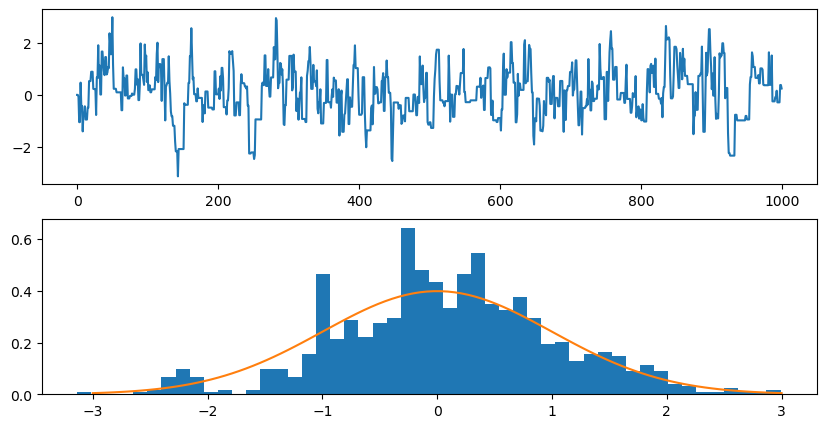

In [7]:
fig,ax = plt.subplots(2,1, figsize=(10,5))
ax[0].plot(MH_samples)
ax[1].hist(MH_samples, density=True, bins=50)
x = np.linspace(-3,3,100)
ax[1].plot(x, target_dist.pdf(x))

In [8]:
# Acceptance Rate
(MH_samples[:-1]!=MH_samples[1:]).sum()/(T-1)
# Hmm... kinda wasteful...

0.5365365365365365